[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vinnu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinnu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/30


C:\Users\vinnu\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


239/239 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.2262 - loss: 1.7856 - precision: 0.3478 - recall: 0.0039 - val_accuracy: 0.4580 - val_loss: 1.5711 - val_precision: 0.9659 - val_recall: 0.0111 - learning_rate: 1.0000e-04
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 51s 212ms/step - accuracy: 0.4311 - loss: 372648.2500 - precision: 0.8605 - recall: 0.1086 - val_accuracy: 0.5024 - val_loss: 1.4413 - val_precision: 0.9681 - val_recall: 0.1075 - learning_rate: 1.0000e-04
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 207ms/step - accuracy: 0.4840 - loss: 10477375488.0000 - precision: 0.8388 - recall: 0.1958 - val_accuracy: 0.5069 - val_loss: 1.4229 - val_precision: 0.9659 - val_recall: 0.1225 - learning_rate: 1.0000e-04
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.4902 - loss: 781379264.0000 - precision: 0.8415 - recall: 0.2048 - val_accuracy: 0.5103 - val_loss: 1.4080 - val_precision: 0.9520 - val_recall: 0.1300 - learning_rate: 1.0000e-04
Epoch 5/30
239/239 ━━━━━

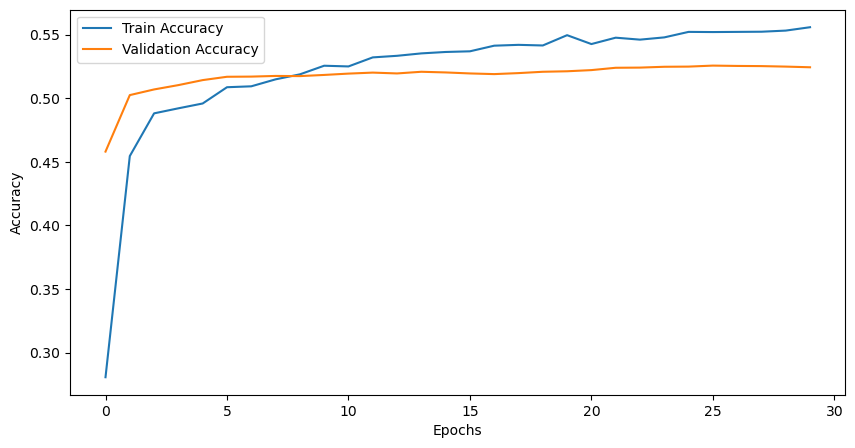

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Text to Predict: This is a tweet about cyberbullying.
Predicted Class: ['not_cyberbullying']


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
dataset_path = 'cyberbullying_tweets.csv'
df = pd.read_csv(dataset_path)

# Clean and preprocess text
nltk.download('punkt')
nltk.download('stopwords')
stemmer = PorterStemmer()

def clean_and_preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    sentences = sent_tokenize(text)
    processed_text = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [token for token in tokens if token not in stopwords.words('english')]
        tokens = [stemmer.stem(token) for token in tokens]
        processed_text.extend(tokens)
    return " ".join(processed_text)

df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_and_preprocess_text)

# Encode labels
encoder = LabelBinarizer()
y = encoder.fit_transform(df['cyberbullying_type'])

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_tweet_text'])
vocab_size = len(tokenizer.word_index) + 1
X_sequences = tokenizer.texts_to_sequences(df['cleaned_tweet_text'])
X_padded = pad_sequences(X_sequences, maxlen=200)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.20, random_state=42)

# Load pre-trained word embeddings (e.g., GloVe)
embeddings_index = {}
with open('glove.6B.200d.txt', encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build and compile the model
model = Sequential([
    Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False),
    GRU(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Train the model with callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Save the model
model.save('Cyber_Bullying_model.h5')

# Plot training history
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction example
def preprocess_text(text):
    text = clean_and_preprocess_text(text)
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=200)
    return padded

# Load the model for prediction
model = load_model('Cyber_Bullying_model.h5')

text_to_predict = "This is a tweet about cyberbullying."
preprocessed_text = preprocess_text(text_to_predict)
prediction = model.predict(preprocessed_text)
predicted_class = encoder.inverse_transform(prediction)

print("Text to Predict:", text_to_predict)
print("Predicted Class:", predicted_class)


In [16]:
def preprocess_text(text):
    text = clean_and_preprocess_text(text)
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=200)
    return padded

# Load the model for prediction
model = load_model('Cyber_Bullying_model.h5')

text_to_predict = " hi my name is karthik "
preprocessed_text = preprocess_text(text_to_predict)
prediction = model.predict(preprocessed_text)
predicted_class = encoder.inverse_transform(prediction)

print("Text to Predict:", text_to_predict)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Text to Predict:  hi my name is karthik 
Predicted Class: ['other_cyberbullying']
